# Deep Convolutional Generative Adversarial Network

## What are GANs?
[Generative Adversarial Networks](https://arxiv.org/abs/1406.2661) (GANs) являются одной из самых интересных идей в современной информатике. Две модели обучаются одновременно с помощью состязательного процесса. Генератор («художник») учится создавать изображения, которые выглядят реальными, а дискриминатор («художник») учится отличать настоящие изображения от подделок.

В ходе обучения генератор постепенно становится лучше создавать изображения, которые выглядят реальными, а дискриминатор лучше различает их. Процесс достигает равновесия, когда дискриминатор больше не может отличать настоящие изображения от подделок.

Этот блокнот демонстрирует этот процесс на наборе данных MNIST. Следующая анимация показывает серию изображений, созданных генератором в ходе его обучения в течение 50 эпох. Изображения начинаются как случайный шум и со временем все больше напоминают рукописные цифры.

![sample output](https://tensorflow.org/images/gan/dcgan.gif)



### Установка

In [ ]:
import tensorflow as tf

In [ ]:
# Генерация GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-vgqjel9m
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-vgqjel9m
  Resolved https://github.com/tensorflow/docs to commit 2b700605aaf42a346624aaff5c84879999d4c407
  Preparing metadata (setup.py) ... done


In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

### Загрузите и подготовьте набор данных

Вы будете использовать набор данных MNIST для обучения генератора и дискриминатора. Генератор будет генерировать рукописные цифры, напоминающие данные MNIST.

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [ ]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Нормализация изображения [-1, 1]

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [ ]:
# Пакетная обработка и перемешивание данных
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Создайте модели

И генератор, и дискриминатор определяются с помощью [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### Генератор

Генератор использует слои tf.keras.layers.Conv2DTranspose (повышающая дискретизация) для создания изображения из начального числа (случайный шум). Начните со слоя «Dense», который принимает это начальное значение в качестве входных данных, затем несколько раз повышайте дискретизацию, пока не достигнете желаемого размера изображения 28x28x1. Обратите внимание на активацию `tf.keras.layers.LeakyReLU` для каждого слоя, кроме выходного слоя, который использует tanh.

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

Используем (пока еще необученный) генератор для создания изображения.

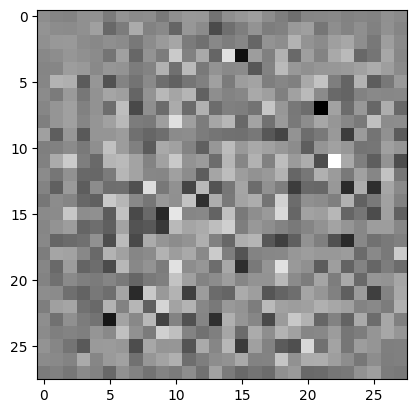

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### Дискриминатор

Дискриминатор — это классификатор изображений на основе CNN.

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Используйте дискриминатор (пока еще необученный), чтобы классифицировать сгенерированные изображения как настоящие или поддельные. Модель будет обучена выводить положительные значения для реальных изображений и отрицательные значения для поддельных изображений.

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00409238]], shape=(1, 1), dtype=float32)


## Определим потери и оптимизаторы

Определите функции потерь и оптимизаторы для обеих моделей.


In [ ]:
# Этот метод возвращает вспомогательную функцию для вычисления потерь перекрестной энтропии.
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Потеря дискриминатора

Этот метод количественно определяет, насколько хорошо дискриминатор способен отличать настоящие изображения от подделок. Он сравнивает прогнозы дискриминатора для реальных изображений с массивом единиц, а прогнозы дискриминатора для поддельных (сгенерированных) изображений — с массивом нулей.

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Потеря генератора
Потери генератора количественно определяют, насколько хорошо ему удалось обмануть дискриминатор. Интуитивно понятно, что если генератор работает хорошо, дискриминатор классифицирует поддельные изображения как настоящие (или 1). Здесь сравните решения дискриминатора по сгенерированным изображениям с массивом единиц.

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

Дискриминатор и оптимизаторы генераторов различаются, поскольку вы будете обучать две сети отдельно.

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Сохранение контрольных точек
В этом блокноте также показано, как сохранять и восстанавливать модели, что может оказаться полезным в случае прерывания длительной задачи обучения.

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Определить цикл обучения


In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# Вы будете повторно использовать это начальное значение(так будет проще)
# для визуализации прогресса в анимированном GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

Цикл обучения начинается с того, что генератор получает на вход случайное начальное число. Это семя используется для создания изображения. Затем дискриминатор используется для классификации реальных изображений (взятых из обучающего набора) и поддельных изображений (созданных генератором). Потери рассчитываются для каждой из этих моделей, а градиенты используются для обновления генератора и дискриминатора.

In [ ]:
# Обратите внимание на использование `tf.function`
# Эта аннотация приводит к «компиляции» функции.
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Создавайте изображения для GIF по ходу обучения
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Сохранить модель каждые 15 эпох
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Генерация финальной эпохи
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

**Создание и сохранение изображений**


In [ ]:
def generate_and_save_images(model, epoch, test_input):
    # Обратите внимание: для параметра «training» установлено значение False.
    # Это значит, что все слои работают в режиме вывода (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Обучите модель
Вызовите метод train(), определенный выше, для одновременного обучения генератора и дискриминатора. Обратите внимание: обучение GAN может оказаться непростой задачей. Важно, чтобы генератор и дискриминатор не подавляли друг друга (например, чтобы они обучались с одинаковой скоростью).

В начале обучения сгенерированные изображения выглядят как случайный шум. По мере обучения сгенерированные цифры будут выглядеть все более реальными. Примерно через 50 эпох они напоминают цифры MNIST. Это может занять около одной минуты/эпохи при настройках Colab по умолчанию.

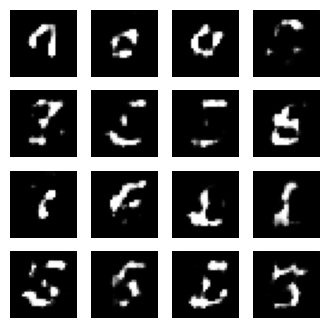

Time for epoch 10 is 697.8093242645264 sec


In [ ]:
train(train_dataset, EPOCHS)

Восстановите последнюю контрольную точку.

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Создание Gif


In [ ]:
# Отобразите одно изображение, используя номер эпохи
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

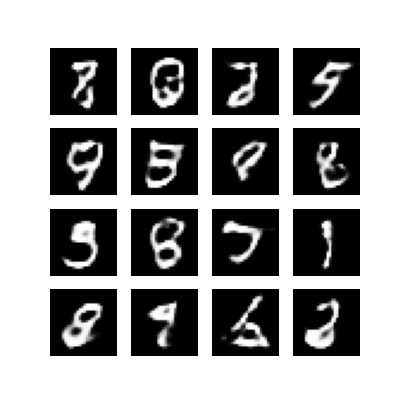

In [ ]:
display_image(EPOCHS)

Используйте imageio, чтобы создать анимированный GIF-изображение, используя изображения, сохраненные во время обучения.

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-26-56bb6d34be2e>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-26-56bb6d34be2e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



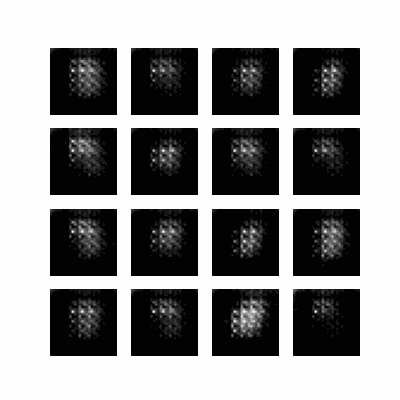

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)